In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

## Use the ggplot style
plt.style.use('ggplot')

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [105]:

datatrain = pd.read_csv("/outputs/sample_fams_bats.csv")
datatrain = pd.read_csv("/outputs/root_train.csv")


## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [106]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [107]:
## Read Predictors
datapred = pd.read_csv('/outputs/sample_predictors.csv')

In [108]:
datacube_clean = datapred.dropna()



In [2]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')



NameError: name 'datacube_clean' is not defined

In [110]:
datafull = datatrain.replace('N.A.',np.nan).astype('float')
Y = datafull.Y

In [52]:
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model:
    #sigma = 1.0
    #range_a=10.13
    #tau = pm.Uniform('tau',0,50)
    tau = pm.HalfNormal('tau',sd=10)
    #sigma = pm.Uniform('sigma',0,10)
    sigma = pm.HalfNormal('sigma',sd=10)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    Tau = pm.gp.cov.Constant(tau)
    cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(ççphi)
    ## Parameters for linear predictor
    b0 = pm.Normal('b0',mu=0,sd=10)
    b = pm.Normal('b',mu=0,sd=10,shape=2)
    mf = pm.gp.mean.Linear(coeffs=[b],intercept=b0) 
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    

    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=Y.values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)
    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)

   

Average Loss = 1,350.2: 100%|██████████| 15000/15000 [1:11:40<00:00,  3.49it/s]
Finished [100%]: Average Loss = 1,350.2
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 1,350.2


CPU times: user 3h 50min 51s, sys: 50min 42s, total: 4h 41min 33s
Wall time: 1h 11min 43s
CPU times: user 1.32 s, sys: 20 ms, total: 1.34 s
Wall time: 1.31 s


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3.22 s, sys: 1.41 s, total: 4.63 s
Wall time: 2.12 s


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ae42bf110>,
      dtype=object)

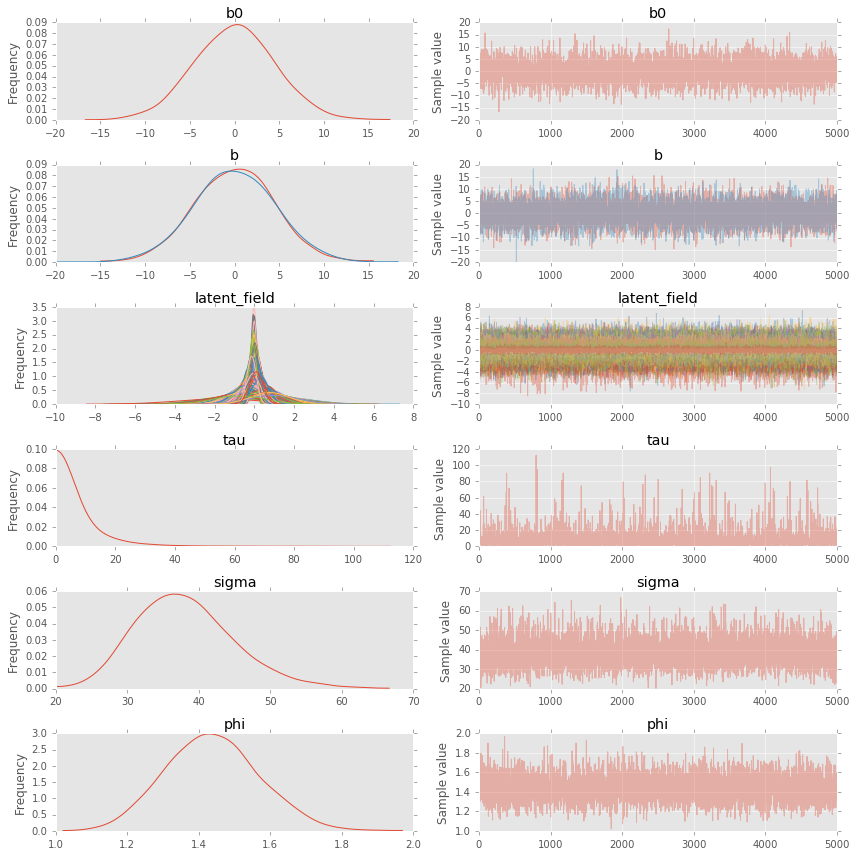

In [53]:
pm.traceplot(trace)

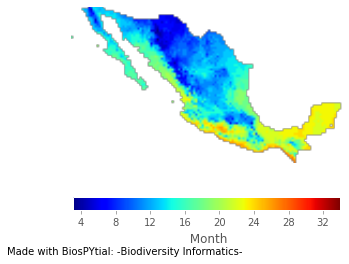

In [54]:
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
elevation = RasterData(rastermodelinstance=MeanTemperature,border=Mexico.geom)
#Rescale to fit same number of pixels
pixel_size = 0.25
elevation.rescale(pixel_size)
elevation.display_field(origin='Lower')

In [55]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [88]:
alpha = sp.logit(0.5)
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/100,axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'prob_gt05':prob_gt05})

In [89]:
#preds['idx'] = data_star.index.values
surface_data['idx'] = datacube_clean.index.values
predictions = datapred.merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
predicted_data = predictions.mean_sample.values

### Using the Raster Container

In [92]:
ql_presences_of_something = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)

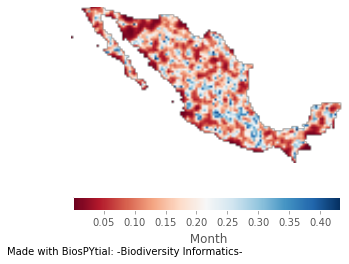

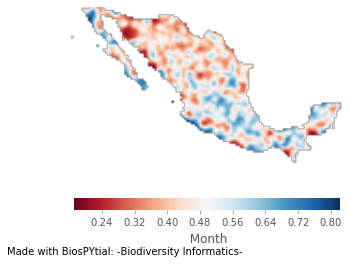

In [94]:
mean_presences_of_something = RasterContainer(predicted_data,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
mean_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)

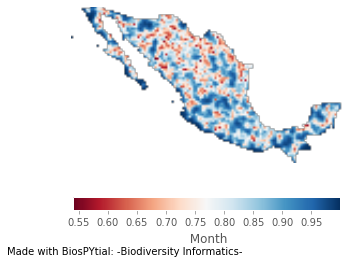

In [95]:
qh_presences_of_something = RasterContainer(predictions.q_975.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
qh_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)

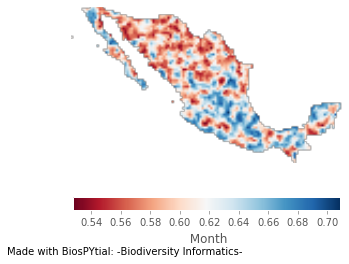

In [100]:
## Probability of the probaaility of presences bigger than 0.5
prob5 = RasterContainer(predictions.prob_gt05.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
prob5.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)

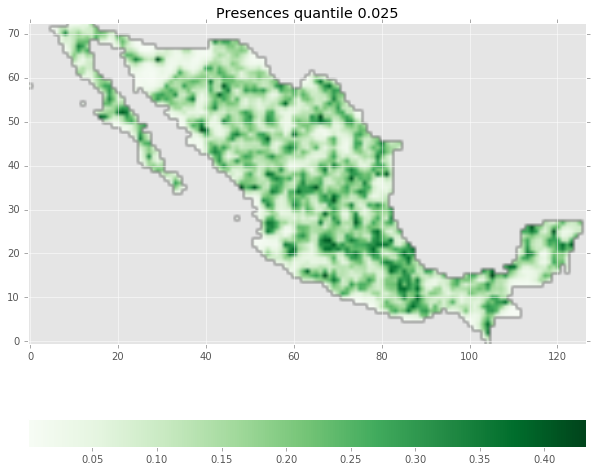

In [96]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
expit(ql_presences_of_something.rasterdata.bands[0].data())
plt.imshow(ql_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens)
plt.title("Presences quantile 0.025")
plt.colorbar(orientation='horizontal')

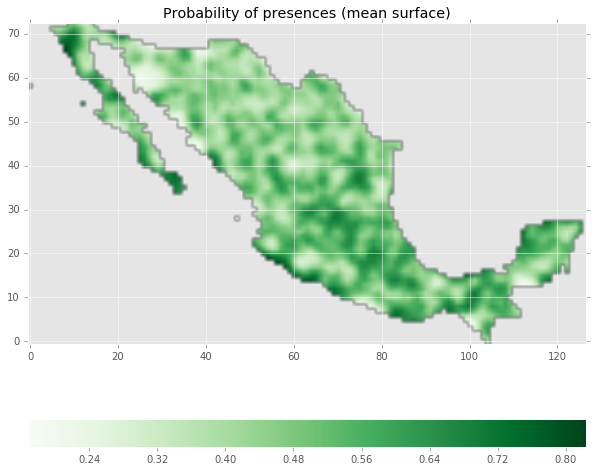

In [97]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(mean_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens)

plt.colorbar(orientation='horizontal')
plt.title('Probability of presences (mean surface)' )

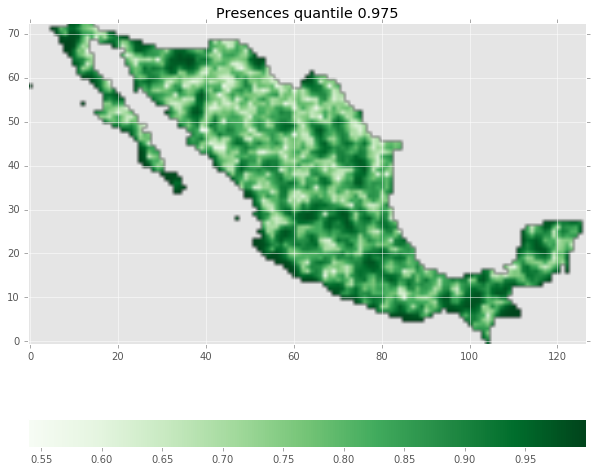

In [98]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(qh_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens)
plt.colorbar(orientation='horizontal')
plt.title("Presences quantile 0.975")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(prob5.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.RdBu)
plt.colorbar(orientation='horizontal')
plt.title("Probability of probability more than 0.5 of presence of the root node")

## Export results to GEotif!

In [99]:
name = "sample_root"
ql_presences_of_something.exportToGeoTiff("ql_"+name)


In [68]:
mean_presences_of_something.exportToGeoTiff("mean_"+name)

In [69]:
qh_presences_of_something.exportToGeoTiff("qh_"+name)

In [101]:
prob5.exportToGeoTiff("prob05"+name)